In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Convolution2D, MaxPooling2D, Flatten, Lambda, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import cv2

import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [16]:
# the data generator
def train_test_split(data_dir, test_size=0.2, load_three=False):
    samples = []
    with open(data_dir + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)

    from sklearn.model_selection import train_test_split
    train_samples, validation_samples = train_test_split(samples, test_size=test_size)
    return train_samples, validation_samples

def generator(samples, batch_size=32):
#     import os
#     import csv
#     import cv2
#     import numpy as np
#     import sklearn

    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
    #             if not load_three: 
    #                         name = './IMG/'+batch_sample[0].split('/')[-1]
                name = "." + batch_sample[0][batch_sample[0].find("/data/"):]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
#                 images.append(name)
                angles.append(center_angle)
    #             else:
    #                 pass

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

#     # compile and train the model using the generator function
#     train_generator = generator(train_samples, batch_size=32)
#     validation_generator = generator(validation_samples, batch_size=32)

#     ch, row, col = 3, 80, 320  # Trimmed image format

#     model = Sequential()
#     # Preprocess incoming data, centered around zero with small standard deviation 
#     model.add(Lambda(lambda x: x/127.5 - 1.,
#             input_shape=(ch, row, col),
#             output_shape=(ch, row, col)))
#     model.add(... finish defining the rest of your model architecture here ...)

#     model.compile(loss='mse', optimizer='adam')
#     model.fit_generator(train_generator, samples_per_epoch= /
#                 len(train_samples), validation_data=validation_generator, /
#                 nb_val_samples=len(validation_samples), nb_epoch=3)

In [12]:
# train_samples, validtion_samples = train_test_split("./data/")

# count = 0
# for i in range(3):
#     for t, v in generator(train_samples, batch_size=2000):
#         count += 1
#     #     if count == 10: 
#     #         break
#         print(count, len(t), t[0].shape)

In [4]:
len(train_samples)

19487

In [3]:
def load_center_data(data_dir, with_flip=False):
    # load the data
    X_train = []
    y_train = []

    with open(data_dir + "driving_log.csv") as csv_file:
        reader = csv.reader(csv_file)
        count = 0
        for line in reader:
            path_to_image = "." + line[0][line[0].find("/data/"):]
#             if count == 20:
#               print(path_to_image)  
#                 break
            count += 1
#             try:
#                 if "/count-clockwise" in line[0]:
#                     continue
            if not with_flip:
                X_train.append(cv2.imread(path_to_image)) # center image
    #             X_train.append(cv2.imread(line[0])) # center image
                y_train.append(float(line[3]))  # steering angels 
            else:
                image = cv2.imread(path_to_image)
                X_train.extend([image, np.fliplr(image)]) # center image
                y_train.extend([float(line[3]), -float(line[3])])  # steering angels 
#             except Exception:
#                 print(count, line)
#                 continue
# #             print(path_to_image)
            
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

In [19]:
def load_3_camera_data(data_dir, correction_steer=0.12):
    X_train = []
    y_train = []

    with open(data_dir + "driving_log.csv") as csv_file:
        reader = csv.reader(csv_file)
        count = 0
        for line in reader:
            if count == 40000:
                break
            count += 1
            steer_center = float(line[3])
            for i in range(3):
                path_to_image = "." + line[i][line[i].find("/data/"):]
#                 print(path_to_image)
#                 X_train.append(path_to_image) # center, left, right'\
                X_train.append(cv2.imread(path_to_image)) # center, left, right'\
            y_train.extend([steer_center, steer_center + correction_steer, steer_center - correction_steer])
#             y_train.extend([steer_center, steer_center, steer_center])
    return np.array(X_train), np.array(y_train)

In [22]:
# data_dir = "./data/track1/20170304/"
t = time.time()
X_train, y_train = load_center_data("./data/", with_flip=True) 
# X_train, y_train = load_3_camera_data("./data/", correction_steer=0.24)   ## this model can not pass the second turn
# X_train, y_train = load_3_camera_data("./data/", correction_steer=0.08)
print("Time: " + str(time.time() - t)) 


Time: 10.002829551696777


In [23]:
X_train.shape, y_train.shape

((13814, 160, 320, 3), (13814,))

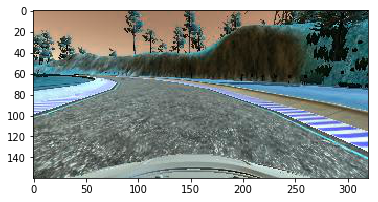

In [24]:
plt.imshow(X_train[0])

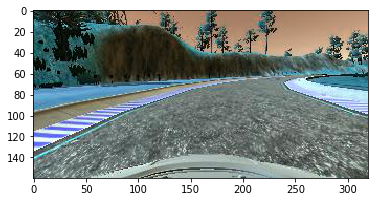

In [25]:
plt.imshow(X_train[1])

In [27]:
y_train[0], y_train[1]

(0.0, -0.0)

In [ ]:
def Lenet():
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    model.add(Convolution2D(6, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(16, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation("relu"))

    model.add(Dense(84))
    model.add(Activation("relu"))

    model.add(Dense(1))
    # model.add(Activation("softmax"))


In [19]:
def Nivdia():
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    
    model.add(Convolution2D(3, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(24, 5, 5, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(36, 3, 3, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Convolution2D(16, 3, 3, border_mode="valid"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation("relu"))

    model.add(Dense(84))
    model.add(Activation("relu"))

    model.add(Dense(1))
    # model.add(Activation("softmax"))
    return model


In [17]:
model = Nivdia()

train_samples, validation_samples = train_test_split('./data/')

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(loss='mse', optimizer="adam")

model.fit_generator(train_generator, samples_per_epoch= \
                len(train_samples), validation_data=validation_generator, 
                nb_val_samples=len(validation_samples), nb_epoch=1)

model.save("model-lenet-0314.h5")


Epoch 1/1
19487/19487 [==============================] - 39s - loss: 0.0376 - val_loss: 0.0338

In [28]:

model = Nivdia()
# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = SGD(lr=0.001)
model.compile(loss='mse', optimizer="adam")
# shuffle(X_train, y_train)
print(len(X_train), len(y_train))
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=10, batch_size=240)
model.save("model-lenet-0314.h5")


13814 13814
Train on 11051 samples, validate on 2763 samples
Epoch 1/10
11051/11051 [==============================] - 25s - loss: 0.0464 - val_loss: 0.1977

In [2]:
# samples = []
# data_dir = './data/track1/20170304/'
# with open(data_dir + 'driving_log.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         samples.append(line)

# train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
#                 name = data_dir + './IMG/'+batch_sample[0].split('/')[-1]
#                 center_image = cv2.imread(name)
#                 center_angle = float(batch_sample[3])
#                 images.append(center_image)
#                 angles.append(center_angle)

#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield sklearn.utils.shuffle(X_train, y_train)

In [3]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
# validation_generator = generator(validation_samples, batch_size=32)

In [42]:
for X_train in next(train_generator):
    len(X_train)